In [17]:
!pwd

/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease


In [1]:
import numpy as np
import yaml
import os
import shutil
import glob
from clease.settings import Concentration
from clease.settings import CEBulk
from clease.structgen import NewStructures
from ase.db import connect
from ase.io import read as ase_read
from ase.visualize import view
from ase.calculators.eam import EAM
from clease.tools import update_db
from clease import Evaluate
from clease import NewStructures
from clease.calculator import attach_calculator
from clease.montecarlo import Montecarlo
import clease

# from gpaw import GPAW
from ase.calculators.emt import EMT
import json

import clease.plot_post_process as pp
import matplotlib.pyplot as plt

[ggggggg:20252] tcp_peer_recv_connect_ack: invalid header type: 57
[ggggggg:20252] tcp_peer_recv_connect_ack: invalid header type: 57
[ggggggg:20252] tcp_peer_recv_connect_ack: invalid header type: 57
[ggggggg:20252] tcp_peer_recv_connect_ack: invalid header type: 57
[ggggggg:20252] tcp_peer_recv_connect_ack: invalid header type: 84
[ggggggg:20252] tcp_peer_recv_connect_ack: invalid header type: 84


In [2]:
with open('LiNa-example.yaml', 'r') as file:
    options = yaml.safe_load(file)


In [3]:
if "LAMMPS" in options:
        from ase.calculators.lammpslib import LAMMPSlib
        print("LAMMPS calc!")
        ASElammps = LAMMPSlib(**options["LAMMPS"])

# cmds = ["pair_style eim",
#         "pair_coeff * * Na Li /Users/Michael_wang/Documents/venkat/cleaseASEcalc/ffield.eim Na Li"]
# rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiNa"
# ASElammps = LAMMPSlib(lmpcmds=cmds, atom_types={'Na':1, 'Li':2}, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlog.log"))

LAMMPS calc!


In [4]:
# from ase.calculators.lammpslib import LAMMPSlib

# cmds = ["pair_style meam",
#         "pair_coeff * * /Users/Michael_wang/Documents/venkat/MEAM/library.meam Li Mg /Users/Michael_wang/Documents/venkat/MEAM/LiMg.meam Li Mg"]
# rootDir = "/Users/Michael_wang/Documents/venkat/cleaseASEcalc/LiMg"
# ASElammps = LAMMPSlib(lmpcmds=cmds, atom_types={'Li':1, 'Mg':2}, keep_alive=True, log_file=os.path.join(rootDir, "LAMMPSlogMg.log"))

In [5]:
import re, numpy
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter, ExpCellFilter, StrainFilter

def get_conc_from_formula(formula):
    GroundStates = options["GroundStates"]
    myKey = options["CLEASE"][GroundStates[0]]["CESettings"]["concentration"][0][0] + '|' +  options["CLEASE"][GroundStates[0]]["CESettings"]["concentration"][0][1]
    sperated = re.split(myKey, formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        return int(sperated[1])/(int(sperated[2]) + int(sperated[1]))
    elif len(sperated) == 2:
        if formula[:2] == options["CLEASE"][GroundStates[0]]["CESettings"]["concentration"][0][0]:
            return 1
        elif formula[:2] == options["CLEASE"][GroundStates[0]]["CESettings"]["concentration"][0][1]:
            return 0
    return numpy.inf

def calculate_energies(db_name, myCalc, DEBUG = 0):
    db = connect(db_name)

    # finalScale = np.array(finalScale)
    # finalX = np.array(finalX)
    Xs = []
    Ss = []

    for row in db.select(converged=False):
        fomula = row.formula
        x = get_conc_from_formula(fomula)
        atoms = row.toatoms()
        atomsInit = atoms.copy()
        oldV = atoms.cell.volume
        atoms.calc = myCalc

        ucf = UnitCellFilter(atoms)
        opt = BFGS(ucf)
        opt.run(fmax=0.02)
        atoms.get_potential_energy()
        
        finalScale = atoms.cell.volume/oldV
        print("at x =", x, "scale =", finalScale)
        Xs.append(x)
        Ss.append(finalScale)

        update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
    return Xs, Ss

def get_num(input_string, A, B):
        elements = re.findall(A+'|'+B+'|\d+', input_string)
        separated_array = []

        for element in elements:
            if element.isdigit():
                separated_array.append(int(element))
            else:
                separated_array.append(element)
            
        ACount = 0
        BCount = 0
        
        for idx, i in enumerate(separated_array):
            if i == A:
                ACount += 1
            elif i == B:
                BCount += 1
            elif isinstance(i, int):
                if separated_array[idx-1] == A:
                    ACount += i-1
                elif separated_array[idx-1] == B:
                    BCount += i-1
    
        return [ACount, BCount]

In [6]:
GroundStates = options["GroundStates"]
gs_name = GroundStates[0]
db_name = options["CLEASE"][gs_name]["CESettings"]["db_name"]
conc = Concentration(basis_elements=options["CLEASE"][gs_name]["CESettings"]["concentration"])
tmp = basis_elements=options["CLEASE"][gs_name]["CESettings"].copy()
tmp['concentration'] = conc
hhsettings = CEBulk(**tmp)

# db_name = "LiMg/bcc-NQP2-newInsert.db"

# hhsettings = CEBulk(crystalstructure='hcp',
#                   a=3.17,
#                   c=5.14,
#                   supercell_factor=64,
#                   concentration=conc,
#                   db_name=db_name,
#                   max_cluster_dia=[5.5,5.5,5.5],
#                   basis_func_type="polynomial")

# db_name = "LiMg/LiMg-Sep11-first-Batch-bcc-NQP.db"

# hhsettings = CEBulk(crystalstructure='bcc',
#                   a=4.33,
#                   supercell_factor=64,
#                   concentration=conc,
#                   db_name=db_name,
#                   max_cluster_dia=[5,5,5],
#                   basis_func_type="polynomial")

In [17]:
template = hhsettings.prim_cell.copy()
template.numbers[0] = 11
template *= (6,6,6)
template.write(gs_name+str(216)+"-gs.db")

In [9]:
genNum = 200

In [10]:
template = hhsettings.prim_cell.copy()

template *= (4,4,4)

numberOfConc = 10
for i in range(numberOfConc):
    ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
    # ns.generate_random_structures(atoms=template, conc=np.array([i/(numberOfConc-1), 1-i/(numberOfConc-1)]))
    ns.generate_random_structures(atoms=template, conc=np.array([(i/(numberOfConc-1))*0.6+0.2, (1-i/(numberOfConc-1))*0.6+0.2]))
    # ns.generate_random_structures(atoms=template, conc=np.array([0.3,0.7]))

    genNum += 1

In [11]:
ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=20)
ns.generate_probe_structure()
genNum += 1

In [11]:
#This is for demo only
db_name2 = db_name[:-3]+"2.db"
! cp $db_name $db_name2

In [27]:
tmpDB = connect(db_name)
count = 0
for i in tmpDB.select("struct_type=initial"):
    print(i)
    count += 1

print(count)


<AtomsRow: formula=Na64, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li3Na61, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li7Na57, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li10Na54, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li13Na51, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li17Na47, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li20Na44, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li24Na40, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li27Na37, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li30Na34, keys=gen,converged,started,queued,name,formula_unit,struct_type>
<AtomsRow: formula=Li34Na30, keys=gen,converged,started,queued,nam

      Step     Time          Energy         fmax
BFGS:    0 18:14:03      -84.345609        0.7907
BFGS:    1 18:14:03      -84.469741        0.7909
BFGS:    2 18:14:03      -84.964835        0.7896
BFGS:    3 18:14:03      -85.458816        0.7880
BFGS:    4 18:14:03      -85.951370        0.7861
BFGS:    5 18:14:03      -86.442171        0.7838
BFGS:    6 18:14:03      -86.930884        0.7812
BFGS:    7 18:14:03      -87.417164        0.7782
BFGS:    8 18:14:03      -87.900654        0.7749
BFGS:    9 18:14:03      -88.380992        0.7712
BFGS:   10 18:14:03      -88.857807        0.7671
BFGS:   11 18:14:03      -89.330720        0.7627
BFGS:   12 18:14:03      -89.799348        0.7578
BFGS:   13 18:14:03      -90.263304        0.7525
BFGS:   14 18:14:03      -90.722196        0.7468
BFGS:   15 18:14:03      -91.175633        0.7407
BFGS:   16 18:14:03      -91.623220        0.7341
BFGS:   17 18:14:03      -92.064568        0.7271
BFGS:   18 18:14:03      -92.499287        0.7196
B

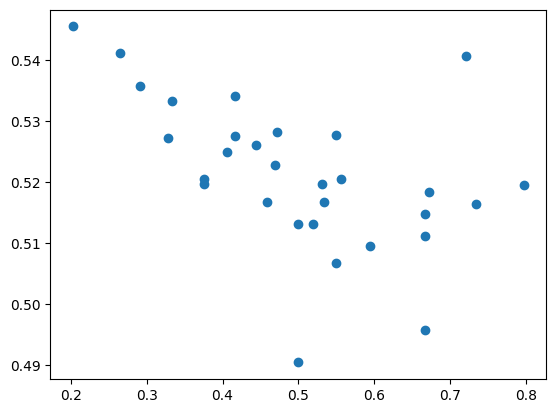

In [12]:
if "LAMMPS" in options:
    Xs, Ss = calculate_energies(db_name, ASElammps, DEBUG=1)
    plt.plot(Xs, Ss, 'o')

In [13]:
# for demo only!
if "LAMMPS" in options:
    DFT_db_name = db_name[:-3] + "-DFTresult.db"
    !cp $db_name $DFT_db_name
    db2delete = connect(DFT_db_name)
    db2delete.delete(range(22))
    !ase db LiNa-demo-DFTresult.db --limit=0

id|age|user        |formula |calculator|  energy|natoms| fmax|pbc|  volume|charge|    mass| smax
22| 8s|Michael_wang|Na64    |lammpslib | -72.499|    64|0.000|TTT|2676.254| 0.000|1471.345|0.000
23| 7s|Michael_wang|Li7Na57 |lammpslib | -75.295|    64|0.017|TTT|2585.934| 0.000|1358.997|0.000
24| 7s|Michael_wang|Li14Na50|lammpslib | -78.329|    64|0.018|TTT|2497.632| 0.000|1246.648|0.000
25| 6s|Michael_wang|Li21Na43|lammpslib | -81.570|    64|0.014|TTT|2412.149| 0.000|1134.300|0.000
26| 6s|Michael_wang|Li28Na36|lammpslib | -85.089|    64|0.016|TTT|2321.905| 0.000|1021.952|0.000
27| 5s|Michael_wang|Li36Na28|lammpslib | -89.370|    64|0.010|TTT|2223.907| 0.000| 893.554|0.000
28| 5s|Michael_wang|Li43Na21|lammpslib | -93.395|    64|0.016|TTT|2138.916| 0.000| 781.205|0.000
29| 5s|Michael_wang|Li50Na14|lammpslib | -97.707|    64|0.018|TTT|2051.679| 0.000| 668.857|0.000
30| 4s|Michael_wang|Li57Na7 |lammpslib |-102.291|    64|0.017|TTT|1967.845| 0.000| 556.508|0.000
31| 4s|Michael_wang|Li64    |l

In [29]:
# demo only
if "LAMMPS" in options:
    !ase db $db_name2 --limit=0

In [26]:
if "DFT" in options:
    from KianCalculator import KianCalc
    calc = KianCalc(energyFile=options["DFT"]["DFT_energy_file"], 
                    formationEBasis=options["CLEASE"][GroundStates[0]]["CESettings"]["concentration"][0])

    db = connect(options["CLEASE"]["CESettings"]["db_name"])

    for row in db.select(converged=False):
        atoms = row.toatoms()
        atoms.calc = calc
        if calc.has_energy(atoms.symbols.formula._formula):
            atoms.get_potential_energy()
            update_db(uid_initial=row.id, final_struct=atoms, db_name=db.filename)

done init!
Na64 -72.49943370861646
LiNa27LiNaLiNa4LiNa5LiNa6LiNa9LiNa5 -75.29466309421092
NaLiNaLi2Na3LiNa7LiNa3LiNa5Li2NaLiNa5LiNa2LiNa5Li3Na17 -78.32854847121882
Na8Li2Na3LiNa2Li2Na2LiNa2Li2Na2LiNaLi2Na3LiNa3LiNa2Li2Na2LiNa4LiNa2LiNa3Li2Na4Li -81.57000099103128
Na2LiNa6LiNa2LiNaLiNaLi4NaLiNaLiNa2LiNa3Li4Na3LiNa2LiNa3Li2NaLiNaLiNaLi3NaLi2Na2LiNaLiNa2 -85.0892336359852
NaLiNa3LiNaLiNaLiNa4Li6NaLi3Na2Li3Na2LiNaLi2NaLiNaLiNaLi5Na3LiNaLi4NaLiNa3LiNaLi3 -89.3699383522405
Li13Na2Li4Na2Li5Na2LiNa2Li2NaLi3Na2Li2Na2LiNaLiNa2Li3NaLiNaLi4Na2Li3Na -93.39492078314716
LiNaLiNaLi2Na3LiNaLi3NaLi6NaLi4NaLi7NaLi9Na2Li10NaLiNaLi5 -97.70693416677123
Li23NaLi9NaLi4NaLi5NaLi5NaLi6NaLi3NaLi2 -102.29127303365725
Li64 -107.2560058536448
NaLi3Na2Li3NaLiNaLiNa3LiNa2Li3NaLi4NaLiNa2LiNa3Li2Na2LiNa2 -57.195842517671885
LiNa3LiNaLiNaLi2Na4Li2Na4LiNa2Li2Na2Li3Na2 -42.065655108909084
NaLiNaLiNaLi2NaLiNa5Li2NaLiNa2Li2Na2Li3Na8Li3Na2LiNaLiNaLi -59.467277613754895
LiNaLiNaLi2NaLiNaLiNaLiNaLiNaLiNa2Li3NaLi2Na3LiNa3Li2NaL

/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/clease/convexhull.py:377: RuntimeWarning: invalid value encountered in divide
  data[:, -1] /= normalization
/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/clease/convexhull.py:384: RuntimeWarning: invalid value encountered in scalar divide
  data_vec[-1] = form_energy / normalization
/Users/Michael_wang/Documents/venkat/mint-PD/PhaseDiagram-Clease/clease/convexhull.py:384: RuntimeWarning: divide by zero encountered in scalar divide
  data_vec[-1] = form_energy / normalization
/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_50661/2472652496.py:8: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(**CEFittingOptions["regularization"])


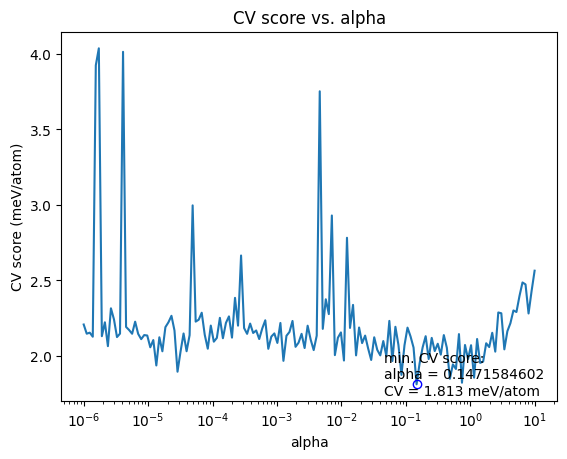

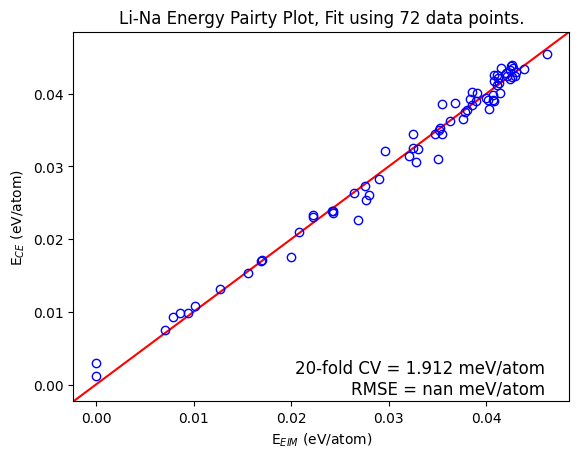

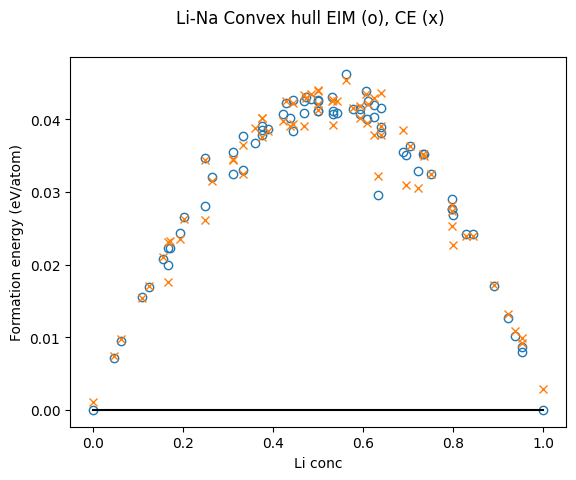

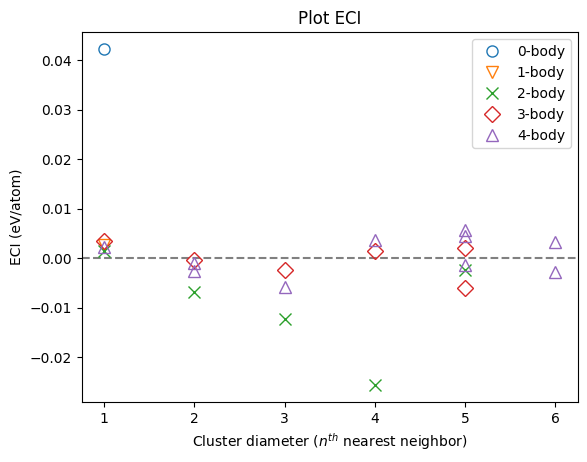

In [7]:
%matplotlib inline
with open('LiNa-example.yaml', 'r') as file:
    options = yaml.safe_load(file)
CEFittingOptions = options["CLEASE"][GroundStates[0]]["CEFitting"]
eva = Evaluate(settings=hhsettings, scoring_scheme=CEFittingOptions["scoring_scheme"], nsplits=CEFittingOptions["nsplits"])
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"])

alpha = eva.plot_CV(**CEFittingOptions["regularization"])

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"], alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

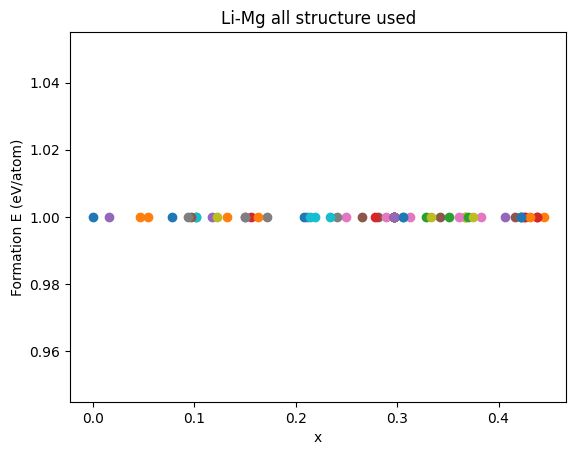

In [8]:
tmp = connect(hhsettings.db_name)
plt.figure()
for i in tmp.select("struct_type=initial"):
    atoms = i.toatoms()
    tmpConc = np.sum(atoms.numbers == 3)/len(atoms.numbers)
    # print(tmpConc, atoms.get_potential_energy())
    # plt.plot(tmpConc, atoms.get_potential_energy()/len(atoms.numbers), 'o')
    plt.plot(tmpConc, 1, 'o')

plt.title("Li-Mg all structure used")
plt.xlabel("x")
plt.ylabel("Formation E (eV/atom)")
plt.show()

In [25]:
%matplotlib qt
tmp = connect('LiMg/LiMg-Oct26-hcp-updated.db')
plt.figure()
for i in tmp.select("struct_type=final"):
    atoms = i.toatoms()
    tmpConc = np.sum(atoms.numbers == 3)/len(atoms.numbers)
    # print(tmpConc, atoms.get_potential_energy())
    plt.plot(tmpConc, atoms.get_potential_energy(), 'o')
plt.show()

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


In [51]:
hhsettings.db_name

'LiMg/LiMg-Oct26-hcp-updated.db'

In [13]:
eciName = options["CLEASE"][GroundStates[0]]["CEFitting"]["ECI_filename"]
if eciName == "FROM DB":
    eciName = db_name + "-eci.json"
eva.save_eci(fname=eciName)

In [15]:
db = connect(db_name)
with open(eciName) as f:
    eci = json.load(f)
iii = 0
skipped = 0
for row in db.select('struct_type=initial, id>141'):
    print("woring on:", iii)
    template = row.toatoms()
    try:
        ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
        ns.generate_gs_structure(atoms=template, init_temp=1e3,
                                    final_temp=1, num_temp=200,
                                    num_steps_per_temp=5000,
                                    eci=eci, random_composition=True)
        genNum += 1
    except:
        skipped += 1
        print(skipped, "structure skipped")
    iii += 1

woring on: 0
1 structure skipped
woring on: 1
woring on: 2
woring on: 3
woring on: 4
woring on: 5
woring on: 6
woring on: 7
woring on: 8
woring on: 9
woring on: 10
woring on: 11
woring on: 12
woring on: 13


Could not generate ground-state structure in 10 attempts.


2 structure skipped
woring on: 14
woring on: 15
woring on: 16
woring on: 17
woring on: 18
woring on: 19
woring on: 20
3 structure skipped
woring on: 21
woring on: 22
woring on: 23
4 structure skipped
woring on: 24
woring on: 25
5 structure skipped
woring on: 26
woring on: 27
woring on: 28
6 structure skipped
woring on: 29
7 structure skipped


      Step     Time          Energy         fmax
BFGS:    0 18:36:36      -76.915866        0.9525
BFGS:    1 18:36:36      -77.071067        0.9525
BFGS:    2 18:36:36      -77.659254        0.9510
BFGS:    3 18:36:36      -78.246429        0.9511
BFGS:    4 18:36:36      -78.832012        0.9515
BFGS:    5 18:36:36      -79.415399        0.9513


BFGS:    6 18:36:36      -79.995961        0.9506
BFGS:    7 18:36:36      -80.573049        0.9493
BFGS:    8 18:36:36      -81.146001        0.9473
BFGS:    9 18:36:36      -81.714142        0.9447
BFGS:   10 18:36:36      -82.276790        0.9414
BFGS:   11 18:36:36      -82.833268        0.9374
BFGS:   12 18:36:36      -83.382903        0.9326
BFGS:   13 18:36:36      -83.925036        0.9270
BFGS:   14 18:36:36      -84.459031        0.9207
BFGS:   15 18:36:36      -84.984281        0.9135
BFGS:   16 18:36:36      -85.500214        0.9055
BFGS:   17 18:36:36      -86.006306        0.8967
BFGS:   18 18:36:36      -86.502081        0.8870
BFGS:   19 18:36:36      -86.987123        0.8765
BFGS:   20 18:36:36      -87.461082        0.8651
BFGS:   21 18:36:36      -87.923678        0.8529
BFGS:   22 18:36:36      -88.374705        0.8398
BFGS:   23 18:36:36      -88.814037        0.8259
BFGS:   24 18:36:36      -89.241626        0.8113
BFGS:   25 18:36:37      -89.657501        0.7958


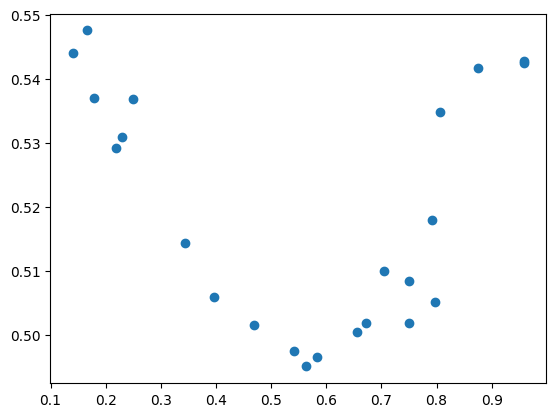

In [16]:
if "LAMMPS" in options:
    Xs, Ss = calculate_energies(db_name, ASElammps, DEBUG=1)
    plt.plot(Xs, Ss, 'o')

/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_19387/4105202473.py:10: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(**CEFittingOptions["regularization"])


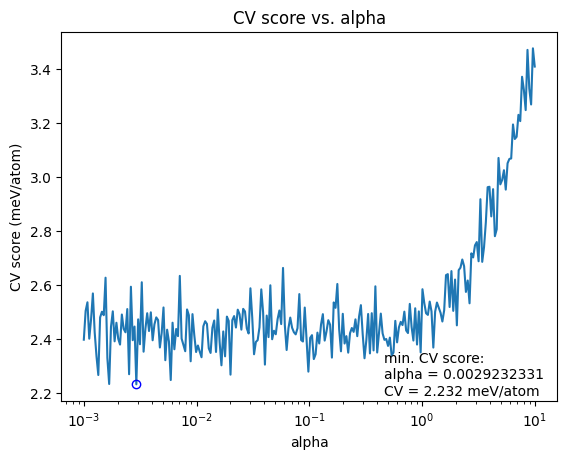

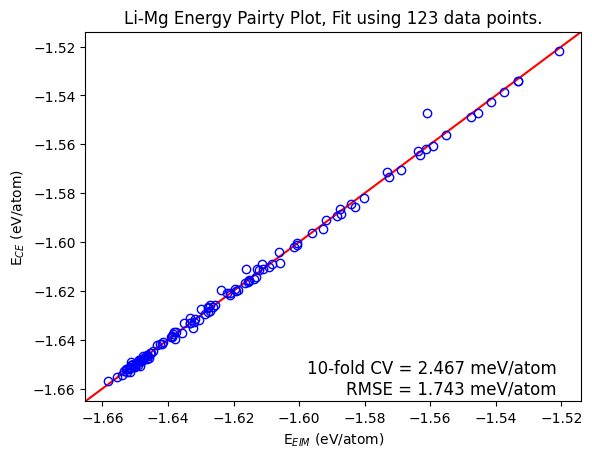

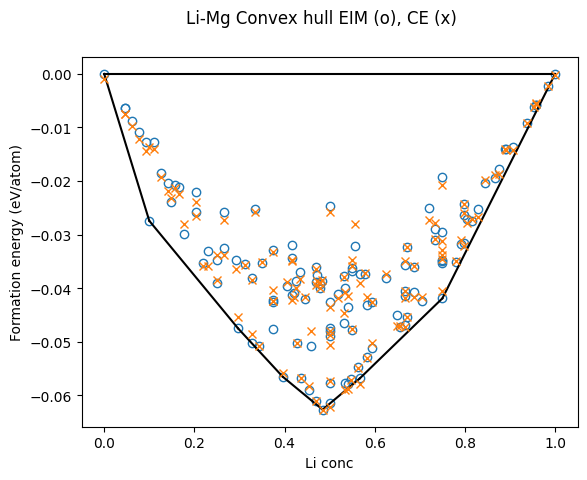

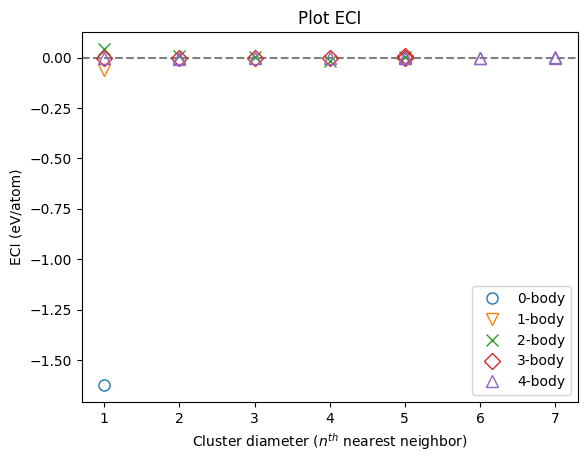

In [17]:
%matplotlib inline

with open('LiMg-example.yaml', 'r') as file:
    options = yaml.safe_load(file)

CEFittingOptions = options["CLEASE"][GroundStates[0]]["CEFitting"]
eva = Evaluate(settings=hhsettings, scoring_scheme=CEFittingOptions["scoring_scheme"], nsplits=CEFittingOptions["nsplits"])
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"])

alpha = eva.plot_CV(**CEFittingOptions["regularization"])

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"], alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

In [61]:
db_name

'LiNa/LiNa-formationE2.db'

In [48]:
genNum

57

In [10]:
genNum = 1

conc = Concentration(basis_elements=[['Li', 'Mg']])

db_name = 'LiMg/LiMg-Oct26-7-hcp-updated-lowE.db'

# hhsettings = CEBulk(crystalstructure='bcc',
#                   a=4.33,
#                   supercell_factor=64,
#                   concentration=conc,
#                   db_name=db_name,
#                   max_cluster_dia=[8,8,8],
#                   basis_func_type="polynomial")

hhsettings = CEBulk(crystalstructure='hcp',
                  a = 3.17,
                  c = 5.14,
                  supercell_factor=64,
                  concentration=conc,
                  db_name=db_name,
                  max_cluster_dia=[7,7,7],
                  basis_func_type="polynomial")

db2insert = connect('LiMg/LiMg-Oct26-formationE-7-hcp.db')
dbDest = connect(db_name)

for idx, row in enumerate(db2insert.select('struct_type=initial')):
    NLi = np.sum(row.numbers == 3)
    NMg = len(row.numbers) - NLi
    # eee = (row.energy - NLi*-1.6483617991 - NMg*-1.5493150298) / len(row.numbers)
    conc = NLi/(NMg+NLi)
    print(conc)
    if conc > 0.8:
        print("skipped")
        continue
    atoms = row.toatoms()
    ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
    ns.insert_structure(atoms)
    genNum += 1
    # break

0.0
0.0546875
0.1015625
0.15625
0.2109375
0.265625
0.3125
0.3671875
0.421875
0.4765625
0.5234375
0.578125
0.6328125
0.6875
0.734375
0.7890625
0.84375
skipped
0.8984375
skipped
0.9453125
skipped
1.0
skipped
0.5
0.5333333333333333
0.5666666666666667
0.3055555555555556
0.65
0.51
0.425
0.4444444444444444
0.4888888888888889
0.421875
0.5
0.42592592592592593
0.5625
0.5104166666666666
0.46875
0.4921875
0.4603174603174603
0.5625
0.4537037037037037
0.4791666666666667
0.1171875
0.28125
0.4453125
0.2890625
0.9375
skipped
0.171875
0.8671875
skipped
0.3671875
0.1015625
0.078125
0.9453125
skipped
0.1328125
0.6015625
0.9609375
skipped
0.328125
0.65625
0.4375
0.15
0.4166666666666667
0.875
skipped
0.3611111111111111
0.75
0.15
0.7
0.12222222222222222
0.453125
0.21875
0.8703703703703703
skipped
0.875
skipped
0.7291666666666666
0.20833333333333334
0.921875
skipped
0.9920634920634921
skipped
0.1625
0.4537037037037037
0.5416666666666666
0.5555555555555556
0.5476190476190477
0.625
0.5
0.5833333333333334
0.370

In [23]:
db2delete = connect('LiMg/LiMg-Oct26-E-8-bcc.db')
db2delete.delete(range(202,225))

In [46]:
tmp = connect('LiMg/LiMg-Oct26-E-bcc.db')
for i in tmp.select(''):
    print(i.formula, i.energy)

Mg64 -97.32880780785695
Li3Mg61 -98.09732129773585
Li7Mg57 -99.16476064425682
Li10Mg54 -99.9341296751898
Li13Mg51 -100.55525932840371
Li17Mg47 -101.48394242215149
Li20Mg44 -102.25671583909717
Li24Mg40 -103.10717537167316
Li27Mg37 -103.5338209622919
Li30Mg34 -103.98895204477213
Li34Mg30 -103.89970208307417
Li37Mg27 -104.55771526998969
Li40Mg24 -104.92814067580335
Li44Mg20 -104.98787046046485
Li47Mg17 -105.3605229356314
Li51Mg13 -105.50320129508923
Li54Mg10 -105.47207861599847
Li57Mg7 -105.43479998089606
Li61Mg3 -105.51067191164783
Li64 -105.49515514162675
Li22Mg28 -80.87225291706885
Li13Mg11 -39.27522043754041
Li7Mg17 -38.01009097711281
Li15Mg9 -39.35925285600769
Li27Mg21 -78.69291817481499
Li16Mg26 -67.80458360545593
Li8Mg8 -26.208210416613166
Li21Mg27 -77.67064878338545
Li26Mg22 -78.29426312961517
Li17Mg19 -58.30750968482446
Li25Mg15 -65.96455977870062
Li15Mg15 -48.80803545041977
Li26Mg10 -59.53314057775578
Li17Mg28 -72.51401690179132
Li25Mg29 -87.61790596640091
Li5Mg10 -24.0012674820

In [11]:
from KianCalculator import KianCalc
calc = KianCalc('LiMg/LiMg-Oct26-E-7-hcp.db', ["Li", "Mg"], [-1.6483617991, -1.5493150298])

db = connect('LiMg/LiMg-Oct26-7-hcp-updated-lowE.db')

for row in db.select(converged=False):
    atoms = row.toatoms()
    atoms.calc = calc
    if calc.has_energy(atoms.symbols.formula._formula):
        atoms.get_potential_energy()
        update_db(uid_initial=row.id, final_struct=atoms, db_name=db.filename)

done init!
Mg128 4.601787395586143e-09
Mg24LiMg27LiMg12LiMg4LiMg25LiMg25LiMg3LiMg -0.5241989441634871
Mg16LiMg27Li2Mg6LiMg3Li2Mg8LiMg2LiMg16LiMg14LiMgLi2Mg8LiMg14 -0.9324663375409159
Mg4LiMg6LiMgLiMg6LiMg2Li2Mg2LiMgLiMg9LiMg2LiMg11LiMg7LiMg11LiMg5LiMgLiMg9LiMg22LiMgLiMg6Li2Mg2 -1.3923950032965138
LiMg2LiMg4LiMgLi2Mg2LiMgLiMg2LiMg9LiMg6Li2Mg15LiMg2LiMg3LiMg5LiMg3LiMg12LiMgLiMg4LiMg8LiMgLiMg3LiMgLiMg4LiMgLiMg6LiMg3LiMg2 -1.7071431994371835
LiMg2LiMg12LiMgLiMg8LiMg4LiMg4LiMg4LiMg7LiMg4Li2Mg4LiMg4LiMg8LiMg5LiMgLiMgLiMg5Li2MgLi5Mg3LiMg2LiMgLi2Mg4LiMg5LiMg2Li3MgLiMg -2.0356041717437847
LiMg4Li4MgLi2MgLiMg5LiMg4Li3Mg4LiMg5Li2Mg4LiMg2LiMg3LiMg4LiMg3LiMg10Li2MgLiMgLiMg2LiMgLiMg5Li3Mg4LiMgLiMg7LiMg5LiMg2Li2MgLiMg7Li2MgLi2 -2.125997331473087
Mg3LiMg4Li2MgLi2MgLiMgLiMg2LiMg2LiMg3LiMg3Li3Mg4LiMg2LiMg2LiMg2LiMg4LiMg2LiMg2LiMgLi2Mg3LiMg2Li2Mg2LiMgLiMgLi2Mg5LiMg3Li2Mg3LiMg2Li2MgLiMg2LiMgLiMgLiMg4LiMgLi4Mg5LiMgLiMg4Li -2.4869767624051917
Li2MgLi2MgLiMgLi4Mg3Li3MgLiMgLiMg5Li2Mg2Li2MgLiMg2LiMgLiMg2LiMg7L

/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_5111/1741663064.py:10: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(**CEFittingOptions["regularization"])


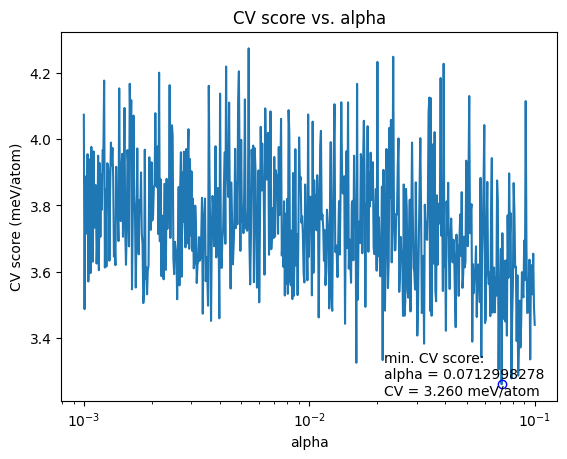

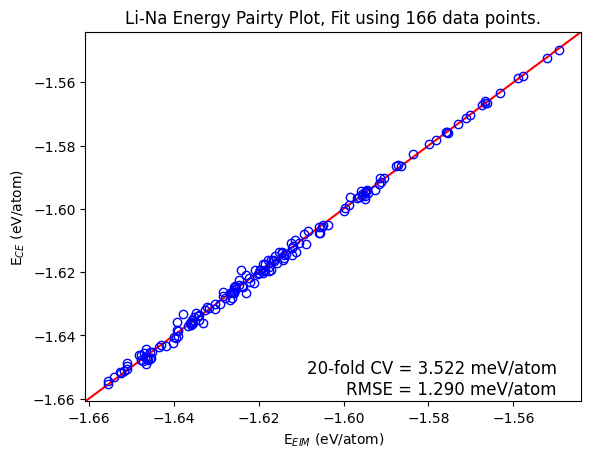

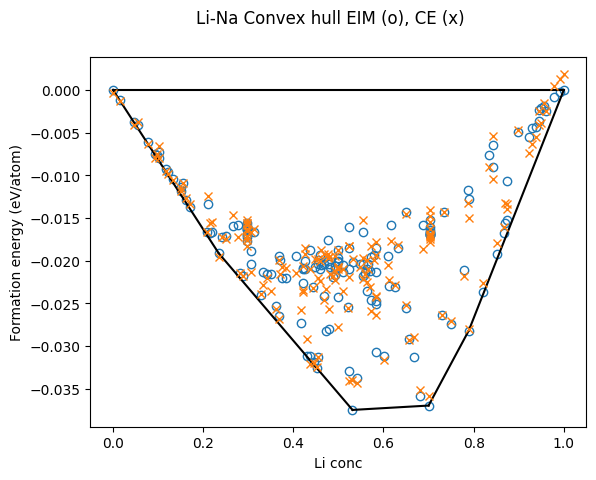

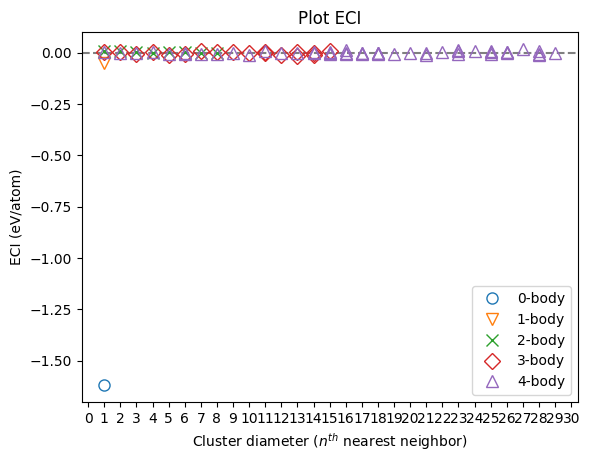

In [19]:
%matplotlib inline

with open('LiMg-example.yaml', 'r') as file:
    options = yaml.safe_load(file)

CEFittingOptions = options["CLEASE"][GroundStates[1]]["CEFitting"]
eva = Evaluate(settings=hhsettings, scoring_scheme=CEFittingOptions["scoring_scheme"], nsplits=CEFittingOptions["nsplits"])
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"])

alpha = eva.plot_CV(**CEFittingOptions["regularization"])

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"], alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

In [49]:
eciName = options["CLEASE"][GroundStates[0]]["CEFitting"]["ECI_filename"]
if eciName == "FROM DB":
    eciName = db_name + "-eci.json"
eva.save_eci(fname=eciName)

In [17]:

eciName = options["CLEASE"][GroundStates[0]]["CEFitting"]["ECI_filename"]
if eciName == "FROM DB":
    eciName = db_name + "-eci.json"

with open(eciName) as f:
    eci = json.load(f)

# eci['c1_0'] = 10
tmp = connect("LiMg/LiMg-Oct26-bcc.db")
for i in tmp.select('struct_type=initial'):
    atoms = i.toatoms()
    # atoms.numbers.fill(12)
    atoms = attach_calculator(hhsettings, atoms, eci)
    print(i.formula, atoms.get_potential_energy())

Mg64 576.0
Li3Mg61 582.0
Li7Mg57 590.0
Li10Mg54 596.0
Li13Mg51 602.0
Li17Mg47 610.0
Li20Mg44 616.0
Li24Mg40 624.0
Li27Mg37 630.0
Li30Mg34 636.0
Li34Mg30 644.0
Li37Mg27 650.0
Li40Mg24 656.0
Li44Mg20 664.0
Li47Mg17 670.0
Li51Mg13 678.0
Li54Mg10 684.0
Li57Mg7 690.0
Li61Mg3 698.0
Li64 704.0
Li22Mg28 494.00000000000006
Li13Mg11 242.0
Li7Mg17 230.0
Li15Mg9 246.0
Li27Mg21 486.0
Li16Mg26 410.00000000000006
Li8Mg8 160.0
Li21Mg27 474.0
Li26Mg22 484.0
Li17Mg19 358.0
Li25Mg15 410.0
Li15Mg15 300.0
Li26Mg10 376.0
Li17Mg28 439.00000000000006
Li25Mg29 536.0
Li5Mg10 145.0
Li12Mg4 168.0
Li9Mg27 342.0
Li9Mg27 342.0
Li44Mg16 628.0
Li51Mg13 678.0
Li54Mg10 684.0
Li27Mg37 630.0
Li35Mg29 646.0
Li31Mg33 638.0
Li53Mg11 682.0
Li36Mg28 648.0
Li63Mg 702.0
Li32Mg32 640.0
Li30Mg34 636.0
Li48Mg16 672.0
Li16Mg48 608.0
Li62Mg2 700.0
Li59Mg5 694.0
Li37Mg27 650.0
Li12Mg52 600.0
Li46Mg18 668.0
Li20Mg44 616.0
Li41Mg23 658.0
Li44Mg6 538.0
Li2Mg22 220.0
Li18Mg6 252.0
Li14Mg34 460.0
Li34Mg8 446.0
Li10Mg6 164.0
Li26Mg22 484.0


In [16]:
eci

{'c0': -0.02019250178307472,
 'c1_0': -0.0015593137799828542,
 'c2_d0000_0_00': 0.005113907377093766,
 'c2_d0001_0_00': 0.00872388909148996,
 'c2_d0002_0_00': 0.0019454312833858838,
 'c2_d0003_0_00': -0.0020187049069917426,
 'c2_d0004_0_00': 0.0030183626995601244,
 'c2_d0005_0_00': 0.002932657228788718,
 'c3_d0000_0_000': 0.0008420000368193095,
 'c3_d0001_0_000': -0.0007400228828623616,
 'c3_d0002_0_000': 0.0017406662585835058,
 'c3_d0003_0_000': -9.338926746756952e-05,
 'c4_d0000_0_0000': -0.001515062286205669,
 'c4_d0001_0_0000': -0.004914855858333763,
 'c4_d0002_0_0000': 0.005452098832445416,
 'c4_d0003_0_0000': 0.0008707573950970382,
 'c4_d0004_0_0000': 0.0021315247616908476,
 'c4_d0005_0_0000': -0.0012698197498976055,
 'c4_d0005_1_0000': -0.001090281822829884,
 'c4_d0006_0_0000': 0.0014872091372468957}

In [27]:
tmp = np.array([1,1,1])
tmp.fill(2)
tmp

array([2, 2, 2])